In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
import jieba
import re
from sklearn.ensemble import RandomForestClassifier
import math
import gc
import warnings
from sklearn.externals import joblib

warnings.filterwarnings('ignore')

def cutwordtostr(sent):
    jieba.load_userdict("C:/Users/Administrator.SC-201905252025/Desktop/test/qg_keywords.txt")
    wordList=jieba.lcut(sent,cut_all=True)
    words = list(set(wordList))
    return [words,' '.join(words)]
    del wordList
    del words
    gc.collect()

def key_count(words):
    keyword = [line.strip() for line in open("C:/Users/Administrator.SC-201905252025/Desktop/test/qg_keywords.txt", 'r', encoding="UTF-8").readlines()]
    count_dict={}
    for i in keyword:
        a=words.count(i)
        if a>0:
            count_dict[i]=a
    return [len(count_dict),sum(count_dict.values())]
    del count_dict
    del a
    del keyword
    gc.collect()

def vectorize(df):
    count_vect = TfidfVectorizer(binary=False,decode_error='ignore')
#     word_vec = count_vect.fit_transform(df['cutwordstr'])
    word_vec = count_vect.fit(df['cutwordstr'])
    joblib.dump(word_vec, 'D://vectorize.m')
#     df['vec'] = word_vec.todense().tolist()
#     return df
#     del count_vect
#     del word_vec
#     gc.collect()

def process(df):
    df['result'] = df['content'].apply(cutwordtostr)
    df['cutword'] = df['result'].apply(lambda x:x[0])
    df['cutwordstr'] = df['result'].apply(lambda x:x[1])

    df['result'] = df['cutword'].apply(key_count)
    df['word_count'] = df['result'].apply(lambda x:x[0])
    df['key_count'] = df['result'].apply(lambda x:x[1])

    df=df.sort_values(by=['key_count'])

    df_positive = df.loc[(df.key_count>2) & (df.word_count>1)]
    df_positive['label'] = 0
    df_negative = df.loc[df.key_count<2,].iloc[0:df_positive.shape[0]]
    df_negative['label'] = 1
    df_train = pd.concat([df_positive,df_negative])
    
    df_train.drop(['key_count', 'word_count', 'cutword', 'result'], axis=1, inplace = True)
    
    vectorize(df)
    
    writer = pd.ExcelWriter("C:/Users/Administrator/Desktop/train.xlsx", engine='xlsxwriter',options={'strings_to_urls':False})
    writer.book.strings_to_urls = False
    df.to_excel(writer, 'Sheet1')
    writer.save()
    print(1)

    # 随机森林
#     model = RandomForestClassifier()
#     model.fit(np.array(df_train['vec']).tolist(), np.array(df_train['label']))
#     df['label'] = model.predict(np.array(df['vec']).tolist())


#     df.to_csv("C:/Users/Administrator.SC-201905252025/Desktop/RF_union.csv", mode='a', header=False, index=False)
#     del df
#     del df_positive
#     del df_negative
#     del df_train
#     del model
#     gc.collect()


if __name__ == "__main__":
    file = pd.read_excel("C:/Users/Administrator.SC-201905252025/Desktop/test/groupchat.xlsx", sheet_name='Sheet1', names=['authaccount','from_id', 'to_id', 'content'])
    df = pd.DataFrame(file)
    process(df)
#     m = df.shape[0]  
#     mini_batch_size = 5000
#     num_complete_minibatches = math.floor(m/mini_batch_size)
    
#     for k in range(0, num_complete_minibatches):
#     for k in range(0, 3):
#         process(df.iloc[k * mini_batch_size : (k + 1) * mini_batch_size, :])
        
#     if m % mini_batch_size != 0:
#         process(df.iloc[num_complete_minibatches * mini_batch_size : , :])

d:\python35\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
d:\python35\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
d:\python35\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
d:\python35\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
d:\python35\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
Bu

1


0.915


<Figure size 432x288 with 0 Axes>

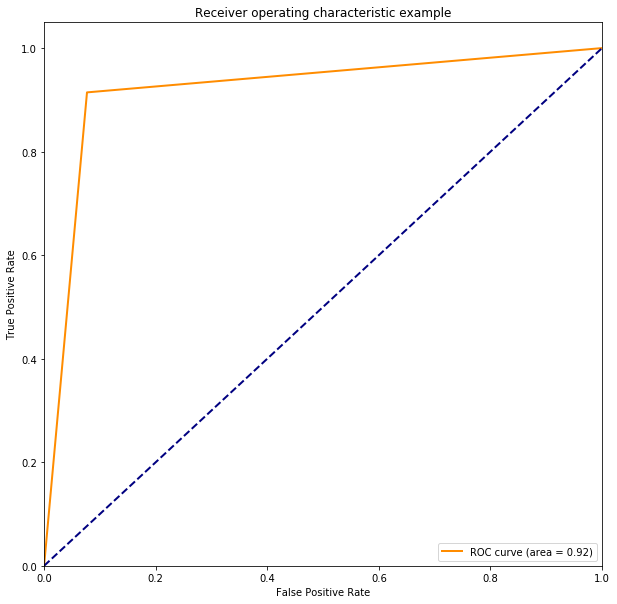

1


In [18]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
import jieba
import re
from sklearn.ensemble import RandomForestClassifier
import math
import gc
import warnings
from sklearn.externals import joblib
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')

def cutwordtostr(sent):
    jieba.load_userdict("C:/Users/Administrator.SC-201905252025/Desktop/test/qg_keywords.txt")
    wordList=jieba.lcut(sent,cut_all=True)
    words = list(set(wordList))
    return [words,' '.join(words)]


def key_count(words):
    keyword = [line.strip() for line in open("C:/Users/Administrator.SC-201905252025/Desktop/test/qg_keywords.txt", 'r', encoding="UTF-8").readlines()]
    count_dict={}
    for i in keyword:
        a=words.count(i)
        if a>0:
            count_dict[i]=a
    return [len(count_dict),sum(count_dict.values())]


def vectorize(df):
    count_vect = TfidfVectorizer(binary=False,decode_error='ignore')
#     word_vec = count_vect.fit_transform(df['cutwordstr'])
    word_vec = count_vect.fit(df['cutwordstr'])
    joblib.dump(word_vec, 'D://vectorize.m')

# def load(filename):
#     with open(filename, "rb") as f:
#         while True:
#             try:
#                 return joblib.load(f)
#             except EOFError:
#                 break

def process(df):
    df['result'] = df['content'].apply(cutwordtostr)
    df['cutword'] = df['result'].apply(lambda x:x[0])
    df['cutwordstr'] = df['result'].apply(lambda x:x[1])
    
    vector = joblib.load("D:/vectorize.m")
    vec = vector.transform(df['cutwordstr'])
#     df.drop(['result','cutwordstr'], axis=1, inplace=True)

#     df['result'] = df['cutword'].apply(key_count)
#     df['word_count'] = df['result'].apply(lambda x:x[0])
#     df['key_count'] = df['result'].apply(lambda x:x[1])

#     df=df.sort_values(by=['key_count'])

#     df_positive = df.loc[(df.key_count>2) & (df.word_count>1)]
#     df_positive['label'] = 0
#     df_negative = df.loc[df.key_count<2,].iloc[0:df_positive.shape[0]]
#     df_negative['label'] = 1
#     df_train = pd.concat([df_positive,df_negative])
    
#     df_train.drop(['key_count', 'word_count', 'cutword', 'result'], axis=1, inplace = True)
    
    # vectorize(df)
    
#     writer = pd.ExcelWriter("C:/Users/ZHX/Desktop/1/train.xlsx", engine='xlsxwriter',options={'strings_to_urls':False})
#     writer.book.strings_to_urls = False
#     df_train.to_excel(writer, 'Sheet1')
#     writer.save()


#     model = RandomForestClassifier()
#     model.fit(vec, np.array(df['label']))
#     joblib.dump(model, "C:/Users/Administrator.SC-201905252025/Desktop/test/RFC.m")
    model = joblib.load("C:/Users/Administrator.SC-201905252025/Desktop/test/RFC.m")
#     df['label'] = model.predict(vec)
    y_score = model.predict(vec)
    
    
    # y_score = svm.fit(X_train, y_train).decision_function(X_test)
    fpr,tpr,threshold = roc_curve(np.array(df['label']), y_score) ###计算真正率和假正率
    print(accuracy_score(np.array(df['label']), y_score))
    roc_auc = auc(fpr,tpr) ###计算auc的值

    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig("C:/Users/Administrator.SC-201905252025/Desktop/test/ROC.png")
    plt.show()

    
#     writer = pd.ExcelWriter("C:/Users/Administrator.SC-201905252025/Desktop/test/result.xlsx", engine='xlsxwriter',options={'strings_to_urls':False})
#     writer.book.strings_to_urls = False
#     df.to_excel(writer, 'Sheet1')
#     writer.save()

    print(1)


if __name__ == "__main__":
#     file = pd.read_excel("C:/Users/Administrator.SC-201905252025/Desktop/test/groupchat.xlsx", sheet_name='Sheet1', names=['authaccount','from_id', 'to_id', 'content'])
    file = pd.read_excel("C:/Users/Administrator.SC-201905252025/Desktop/test.xlsx", sheet_name='Sheet2', names=['authaccount','from_id', 'to_id', 'content','label'])
    df = pd.DataFrame(file)
    process(df)
#     m = df.shape[0]  
#     mini_batch_size = 5000
#     num_complete_minibatches = math.floor(m/mini_batch_size)
    
#     for k in range(0, num_complete_minibatches):
#     for k in range(0, 3):
#         process(df.iloc[k * mini_batch_size : (k + 1) * mini_batch_size, :])
        
#     if m % mini_batch_size != 0:
#         process(df.iloc[num_complete_minibatches * mini_batch_size : , :])